# Analyzing an overexpression optimization experiment
The work shown here was one of a series of experiments run to develop protocols for overexpressing a gene of interest in HUVEC cells. The project was strictly a biology endeavor at this point. Hopefully this showcases some of the analytical approaches and tools I developed for this purpose.<br>

### To run the notebook:
please connect to /172.16.2.31/i_bio and paste the path into 'path_to_i_bio' below<br>
connect to /172.16.2.32/images and paste the path into 'path_to_images' below

In [1]:
path_to_repo = '/Users/chris.johnson/Documents/scripts/python/drug-discovery/Chris_J_portfolio/'
path_to_i_bio = '/Volumes/i_bio/'
path_to_images = '/Volumes/images/'

In [2]:
# Specify a path for the transfection_efficiency.py definitions
import sys
sys.path.insert(0, path_to_repo)

In [3]:
import transfection_efficiency as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [4]:
# Connect to /172.16.2.31/i_bio and /172.16.2.32/images and find paths to your data and images
data_path = path_to_i_bio+'overexpression/190912_BacMam_Echo_1536/'
images_path_384 = path_to_images+'DBCP IXM images/190913-BacMamMM/384well/'
images_path_1536 = path_to_images+'DBCP IXM images/190913-BacMamMM/1536well/'

In [5]:
# Check for connection to images and files
print('path to data:', os.path.exists(data_path))
print('path to images:', os.path.exists(images_path_1536))
if not os.path.exists(data_path) or not os.path.exists(images_path_1536):
    print ('Please check your connection and input paths to the servers shown in the first coding cell')

path to data: True
path to images: True


# Import the CP output data and a formatted layout file
The actual image analysis is a custom project file in cell profiler that I developed for this project. These project files have been included in this repo in case you wish to view them.<br>
The cells are transduced with a BacMam virus contining the GFP gene, which produces a protein that fluoresces at around 488 nm when illuminated with UV light. I use the amount of green fluorescence *per cell* to score the frequency at which cells are infected by the BacMam virus and quantify the amount of the target gene that they are expressing. GFP is serving as a proxy for genes that we will later use to model diseases. These early experiments were executed using BacMam-GFP because of the ease of detecting target gene expression.<br>
The images contain 2 channels, one detecting Hoechst labeling the nuclei and one detecting GFP expression.<br>
The CP file identifies cells based on the nuclei, the quantifies the amount of GFP within the area bounded by each nucleus as a proxy for the amount of GFP expressed in the entire cell.

In [6]:
# Read the layout file (specially formatted file describing what's in the wells and where the controls are)
layout_384 = pd.read_csv(data_path+'plate_layout_384.csv')
layout_1536 = pd.read_csv(data_path+'plate_layout_1536.csv')
layout_384.columns
layout_df = layout_384

In [7]:
# Read the data file
nuc_384 = pd.read_csv(data_path+'BacMam_384_Nuclei.csv')
nuc_1536 = pd.read_csv(data_path+'BacMam_1536_Nuclei.csv')
nuc_384.columns

Index(['ImageNumber', 'ObjectNumber', 'Metadata_ChannelNumber', 'Metadata_Col',
       'Metadata_Col.1', 'Metadata_FileLocation', 'Metadata_Frame',
       'Metadata_Row', 'Metadata_Row.1', 'Metadata_Series', 'Metadata_Site',
       'Metadata_Well', 'Intensity_IntegratedIntensity_CorrGFP',
       'Intensity_MaxIntensity_CorrGFP', 'Intensity_MeanIntensity_CorrGFP',
       'Intensity_UpperQuartileIntensity_CorrGFP', 'Location_Center_X',
       'Location_Center_Y', 'Number_Object_Number'],
      dtype='object')

In [8]:
# From the nuc_df columns, include the fields that need to be quantified
fields = ['Intensity_IntegratedIntensity_CorrGFP',
          'Intensity_MaxIntensity_CorrGFP', 
          'Intensity_MeanIntensity_CorrGFP',
          'Intensity_UpperQuartileIntensity_CorrGFP']

# Normalize by groupings within the plate, each with its own controls
This set of functions compares the amount of GPF per cell in the wells of a given plate and compares them to controls in the same plate. A cell is scored as GFP positive if it has more than the mean + 3 std total fluorescence of the cells in the negative controls. This gives a background level of about 2.5% GFP positive and is a pretty sensitive method to detect low levels of transduction
## Warning: Running this section takes a LONG time.
you can skip the next few cells and  upload the data table in the cell after the next heading below.

In [9]:
layout_df.columns

Index(['destination_well', 'application', 'MOI_reported', 'forward_reverse',
       'is_control'],
      dtype='object')

In [10]:
# define experimental groups by differences in the specified columns
nuc_df = nuc_384
differentiator = ['forward_reverse']
groups = tf.GetExptGroups(layout_df,differentiator)

In [11]:
# walk through the found categories and get the stats. auto add them to a big list

executed = 0

for index, row in groups.iterrows():
    # Get controls based on the same things used to define groups above
    expt_wells, ctrl_wells = tf.GetExptCtrlWells(layout_df, row, differentiator)
    temp_stats = tf.PlateStats('384_well',nuc_df,expt_wells+ctrl_wells,ctrl_wells, fields)
    if executed == 0:
        processed_df = temp_stats.copy()
    else:
        processed_df = pd.concat([processed_df,temp_stats])
    executed += 1

In [12]:
layout_df = layout_1536
nuc_df = nuc_1536

differentiator = ['forward_reverse']
groups = tf.GetExptGroups(layout_df,differentiator)

In [13]:
executed = 0

for index, row in groups.iterrows():
    # Get controls based on the same things used to define groups above
    expt_wells, ctrl_wells = tf.GetExptCtrlWells(layout_df, row, differentiator)
    temp_stats = tf.PlateStats('1536_well',nuc_df,expt_wells+ctrl_wells,ctrl_wells, fields)
    if executed == 0:
        processed_df2 = temp_stats.copy()
    else:
        processed_df2 = pd.concat([processed_df2,temp_stats])
    executed += 1

In [14]:
formatted_384 = tf.PrepareDF(processed_df, layout_384)
formatted_1536 = tf.PrepareDF(processed_df2, layout_1536)

/Users/chris.johnson/Documents/scripts/python/drug-discovery/Chris_J_portfolio/transfection_efficiency.py:244: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  out_df.insert(loc = 1, column = 'column', value = out_df['destination_well'].str.extract(r'([0-9]+)'))
/Users/chris.johnson/Documents/scripts/python/drug-discovery/Chris_J_portfolio/transfection_efficiency.py:245: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  out_df.insert(loc = 1, column = 'row', value = out_df['destination_well'].str.extract(r'([A-Z]+)'))


In [15]:
formatted_df = pd.concat([formatted_384, formatted_1536])

In [16]:
# reformat, join and save, same as above
formatted_df.to_csv(data_path+'BacMam_stats_per_plate_local_controls.csv', index = False)

# OK, now lets look at some images
you can load the results of the previous section in the next cell

In [59]:
formatted_df = pd.read_csv(data_path+'BacMam_stats_per_plate_local_controls.csv')

In [17]:
# Create a list of image files in the image path
image_files_384 = tf.FileList(images_path_384)
image_files_1536 = tf.FileList(images_path_1536)

In [18]:
# Associate the files containing the different channels for each well
image_fileset_384 = tf.MakeFileSet(image_files_384)
image_fileset_1536 = tf.MakeFileSet(image_files_1536)

In [19]:
# Set the relative intensity that will be used to display the 2 channels
nuc_intensity = 10
GFP_intensity = 15

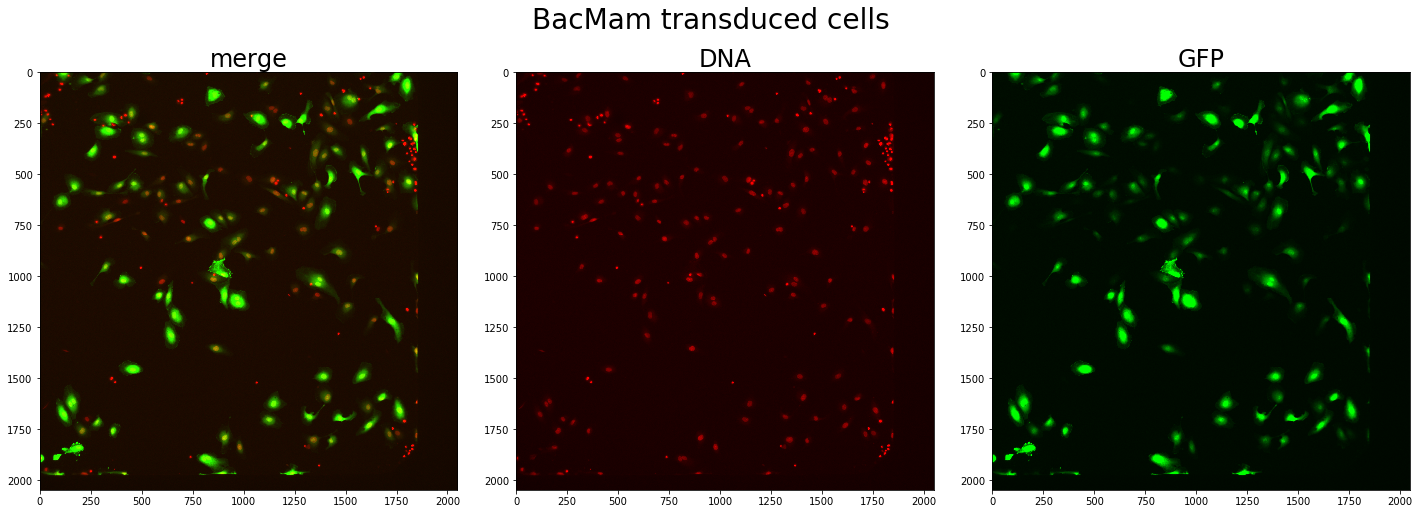

In [20]:
well = 'C03'
merge_title = 'merge'
title = 'BacMam transduced cells'
tf.ShowPanel(well, image_fileset_1536, 
             R_scale = nuc_intensity, G_scale = GFP_intensity, #y_range = [1500,2000], x_range = [800,1300],
             G_title = 'GFP', M_title = merge_title, title = title, Absolute_scale = True)

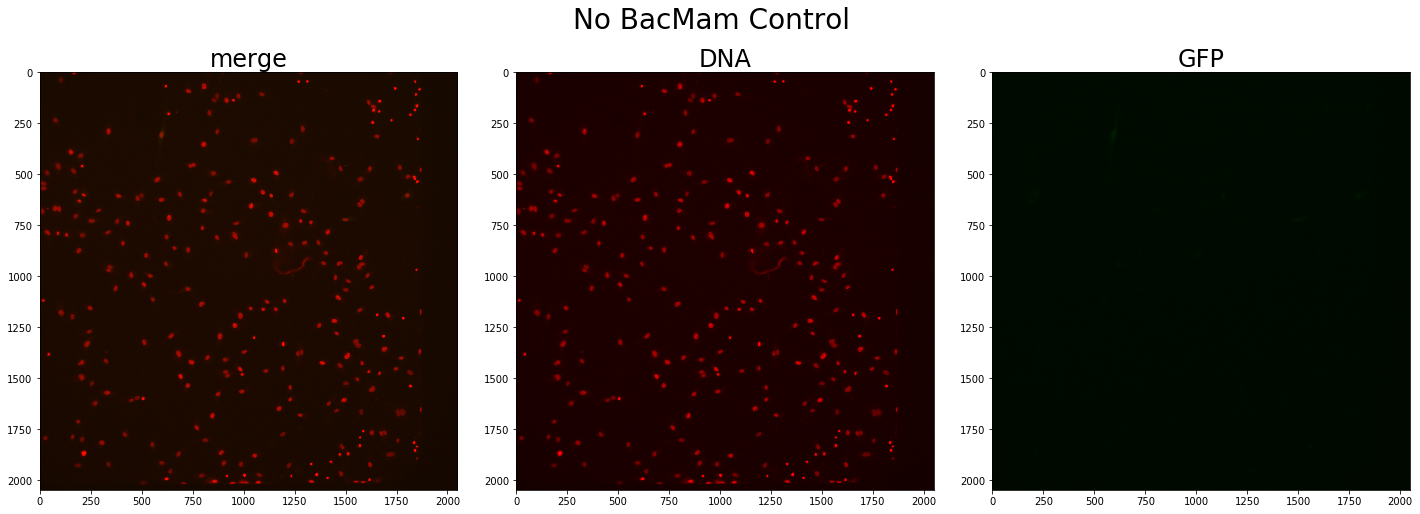

In [21]:
well = 'O04'
merge_title = 'merge'
title = 'No BacMam Control'
tf.ShowPanel(well, image_fileset_1536, 
             R_scale = nuc_intensity, G_scale = GFP_intensity, #y_range = [1500,2000], x_range = [800,1300],
             G_title = 'GFP', M_title = merge_title, title = title, Absolute_scale = True)

From a technical standpoint the experiment has worked. Using fluorescence microscopy we can see that a BacMam-transduced cell culture has GFP expressing cells and that non-transduced culture does not. The visual intensity of the GFP and Hoechst channels has been normalized equally in both images.
## Now to take a global look at how expression levels change with different conditions

In [22]:
formatted_df[200:205]

,destination_well,row,mock_row,column,application,MOI_reported,forward_reverse,is_control,destination_plate_barcode,Intensity_IntegratedIntensity_CorrGFP_positive,Intensity_MaxIntensity_CorrGFP_positive,Intensity_MeanIntensity_CorrGFP_positive,Intensity_UpperQuartileIntensity_CorrGFP_positive,cell_viability,total_cells
200,B05,B,02,05,SP2,100000.0,forward,no,384_well,0.957494,0.982103,0.984340,0.984340,0.519930,447
201,C05,C,03,05,SP2,100000.0,forward,no,384_well,0.961424,0.985163,0.985163,0.985163,0.391983,337
202,D05,D,04,05,SP2,50000.0,forward,no,384_well,0.964151,0.979245,0.981132,0.983019,0.616471,530
203,E05,E,05,05,SP2,50000.0,forward,no,384_well,0.907514,0.951830,0.957611,0.959538,0.603677,519
204,F05,F,06,05,SP2,25000.0,forward,no,384_well,0.893333,0.950000,0.950000,0.951667,0.697892,600


### Can we use the echo? Can we pre-print BacMam?

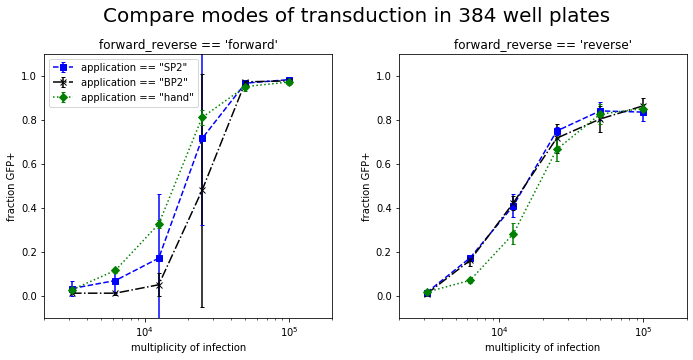

In [53]:
Y = 'Intensity_MeanIntensity_CorrGFP_positive'
X = 'MOI_reported'
data = formatted_df.query("destination_plate_barcode == '384_well'")
query_list = ["forward_reverse == 'forward'","forward_reverse == 'reverse'"]

set3 = ['application == "hand"']
set1 = ['application == "SP2"']
set2 = ['application == "BP2"']

kwargs = {
    'x_label':'multiplicity of infection',
    'y_label':'fraction GFP+',
    'y_range':[-.1,1.1],
    'x_range':[2000,200000],
    'log':True,
    'title':'Compare modes of transduction in 384 well plates',
}

tf.PlotLinesMultiPanel(data, X, Y, query_list,set1,set2,set3, **kwargs)

Transducing with the Echo (BP2, SP2) works as well as transducing by hand, so the echo can be used for BacMam transduction<br>
There does not appear to be much difference between the SP2 and BP2 liquid definitions on the echo.<br>
Adding the cells first (Forward transduction) works better than adding the BacMam first (reverse).<br>
Transduction frequnecy in the mid range for the forward transductions is squirrely, large error bars!
#### Echo yes, preprinting no

### Can we execute in 1536 well plates?

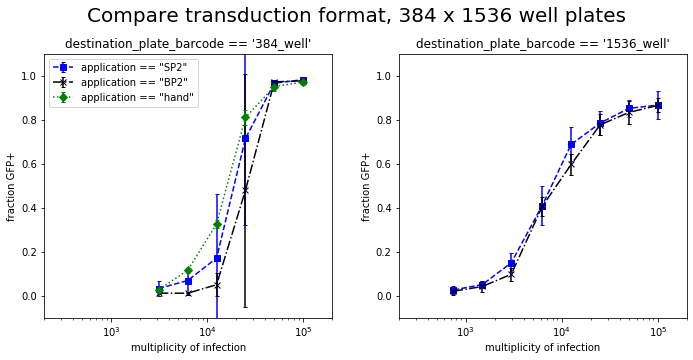

In [57]:
Y = 'Intensity_MeanIntensity_CorrGFP_positive'
X = 'MOI_reported'
data = formatted_df.query("forward_reverse == 'forward'")
query_list = ["destination_plate_barcode == '384_well'","destination_plate_barcode == '1536_well'"]

set3 = ['application == "hand"']
set1 = ['application == "SP2"']
set2 = ['application == "BP2"']

kwargs = {
    'x_label':'multiplicity of infection',
    'y_label':'fraction GFP+',
    'y_range':[-.1,1.1],
    'x_range':[200,200000],
    'log':True,
    'title':'Compare transduction format, 384 x 1536 well plates',
}

tf.PlotLinesMultiPanel(data, X, Y, query_list,set1,set2,set3, **kwargs)

We can execute in 1536 well plates (right panel), but the transduction frequency is a bit lower per amount of BacMam reagent. Please note, it is not possible to apply the BacMam reagent by hand to 1536 well plates

### Any surprises with Forward vs reverse transduction in 1536 well format?

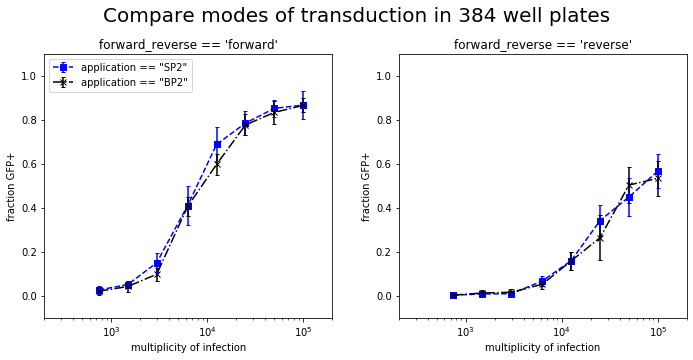

In [58]:
Y = 'Intensity_MeanIntensity_CorrGFP_positive'
X = 'MOI_reported'
data = formatted_df.query("destination_plate_barcode == '1536_well'")
query_list = ["forward_reverse == 'forward'","forward_reverse == 'reverse'"]

set3 = ['application == "hand"']
set1 = ['application == "SP2"']
set2 = ['application == "BP2"']

kwargs = {
    'x_label':'multiplicity of infection',
    'y_label':'fraction GFP+',
    'y_range':[-.1,1.1],
    'x_range':[200,200000],
    'log':True,
    'title':'Compare modes of transduction in 384 well plates',
}

tf.PlotLinesMultiPanel(data, X, Y, query_list,set1,set2,set3, **kwargs)

Forward transduction is markedly better in 1536 well formats too.

## Look at the per-cell intensity distributions from some of the different conditions.
With more BacMam, the transduction frequency is higher. Are the cells expressing more GFP on a per cell basis?<br>
To explore this I'll look at some histograms of the amount of GFP expressed per cell under different conditions

In [26]:
# List out the wells in each group
forward_ctrls_def = {'is_control':'yes','forward_reverse':'forward'}
reverse_ctrls_def = {'is_control':'yes','forward_reverse':'reverse'}
f_hand_100k_def = {'MOI_reported':'100000','forward_reverse':'forward','application':'hand'}
f_hand_50k_def = {'MOI_reported':'50000','forward_reverse':'forward','application':'hand'}
f_hand_25k_def = {'MOI_reported':'25000','forward_reverse':'forward','application':'hand'}
f_BP2_100k_def = {'MOI_reported':'100000','forward_reverse':'forward','application':'BP2'}
f_BP2_50k_def = {'MOI_reported':'50000','forward_reverse':'forward','application':'BP2'}
f_BP2_25k_def = {'MOI_reported':'25000','forward_reverse':'forward','application':'BP2'}
f_SP2_100k_def = {'MOI_reported':'100000','forward_reverse':'forward','application':'SP2'}
f_SP2_50k_def = {'MOI_reported':'50000','forward_reverse':'forward','application':'SP2'}
f_SP2_25k_def = {'MOI_reported':'25000','forward_reverse':'forward','application':'SP2'}
r_hand_100k_def = {'MOI_reported':'100000','forward_reverse':'reverse','application':'hand'}
r_hand_50k_def = {'MOI_reported':'50000','forward_reverse':'reverse','application':'hand'}
r_hand_25k_def = {'MOI_reported':'25000','forward_reverse':'reverse','application':'hand'}
r_BP2_100k_def = {'MOI_reported':'100000','forward_reverse':'reverse','application':'BP2'}
r_BP2_50k_def = {'MOI_reported':'50000','forward_reverse':'reverse','application':'BP2'}
r_BP2_25k_def = {'MOI_reported':'25000','forward_reverse':'reverse','application':'BP2'}
r_SP2_100k_def = {'MOI_reported':'100000','forward_reverse':'reverse','application':'SP2'}
r_SP2_50k_def = {'MOI_reported':'50000','forward_reverse':'reverse','application':'SP2'}
r_SP2_25k_def = {'MOI_reported':'25000','forward_reverse':'reverse','application':'SP2'}

f_ctrl_384 = tf.GetSingleCells(layout_384, nuc_384, forward_ctrls_def)
f_ctrl_1536 = tf.GetSingleCells(layout_1536, nuc_1536, forward_ctrls_def)

f_SP2_100k_384 = tf.GetSingleCells(layout_384, nuc_384, f_SP2_100k_def)
f_SP2_50k_384 = tf.GetSingleCells(layout_384, nuc_384, f_SP2_50k_def)
f_SP2_25k_384 = tf.GetSingleCells(layout_384, nuc_384, f_SP2_25k_def)

f_BP2_100k_384 = tf.GetSingleCells(layout_384, nuc_384, f_BP2_100k_def)
f_BP2_50k_384 = tf.GetSingleCells(layout_384, nuc_384, f_BP2_50k_def)
f_BP2_25k_384 = tf.GetSingleCells(layout_384, nuc_384, f_BP2_25k_def)

f_SP2_100k_1536 = tf.GetSingleCells(layout_1536, nuc_1536, f_SP2_100k_def)
f_SP2_50k_1536 = tf.GetSingleCells(layout_1536, nuc_1536, f_SP2_50k_def)
f_SP2_25k_1536 = tf.GetSingleCells(layout_1536, nuc_1536, f_SP2_25k_def)

f_BP2_100k_1536 = tf.GetSingleCells(layout_1536, nuc_1536, f_BP2_100k_def)
f_BP2_50k_1536 = tf.GetSingleCells(layout_1536, nuc_1536, f_BP2_50k_def)
f_BP2_25k_1536 = tf.GetSingleCells(layout_1536, nuc_1536, f_BP2_25k_def)

## Get an idea of how controls compare to high-expression conditions for the plate formats

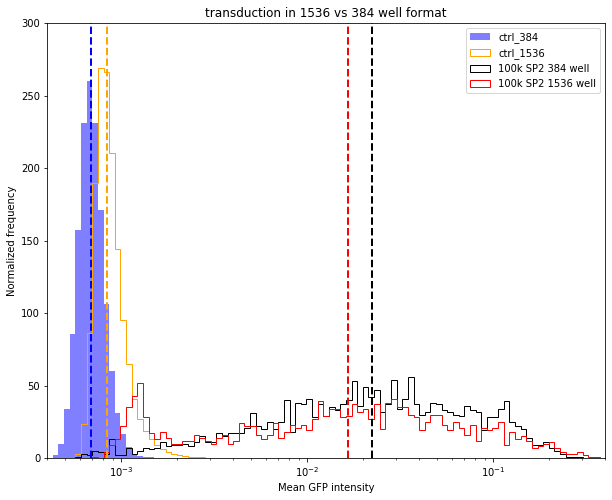

condition : median GFP intensity
ctrl_384 : 0.0006847176859009832
ctrl_1536 : 0.0008389958795094262
100k SP2 384 well : 0.022199035281579873
100k SP2 1536 well : 0.016589428872089983


In [27]:
set1 = ['100k SP2 384 well',f_SP2_100k_384]
set2 = ['100k SP2 1536 well',f_SP2_100k_1536]
set3 = ['50k SP2 384 well',f_SP2_50k_384]
ctrls_384 = ['ctrl_384',f_ctrl_384,.02]
ctrls_1536 = ['ctrl_1536',f_ctrl_1536,.01]

kwargs = {'x_range':[0.0004,.4],
          'y_range':[0,300],
          'bin_num':100,
          'x_label':'Mean GFP intensity',
          'title':'transduction in 1536 vs 384 well format',
          'abs_density':True,
         'log':True
         }

medians = tf.PlotHist(ctrls_384, ctrls_1536, set1, set2, **kwargs)
print ('condition : median GFP intensity')
for i in medians:
    print (i+' : '+str(medians.get(i)))

 It looks like the background GFP intensity is reading a little higher for the 1536 well plates. However, the cells that are expressing have a man expression level almost 2 logs higher than background in both formats.

### Look at a range of BacMam levels (MOI) in the 384 well format

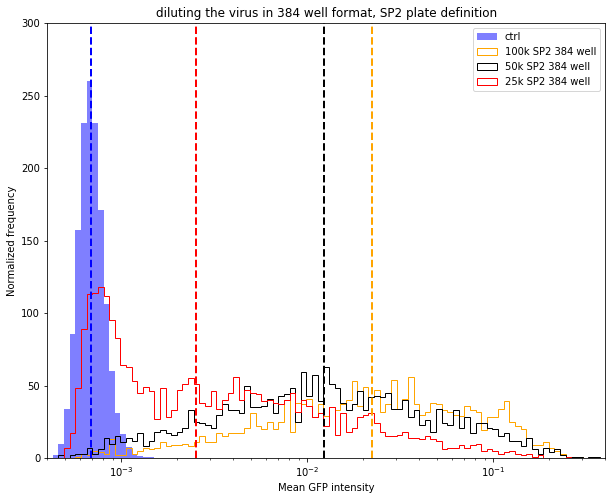

condition : median GFP intensity
ctrl : 0.0006847176859009832
100k SP2 384 well : 0.022199035281579873
50k SP2 384 well : 0.012382277620107322
25k SP2 384 well : 0.002513825820423426


In [28]:
set1 = ['100k SP2 384 well',f_SP2_100k_384]
set2 = ['50k SP2 384 well',f_SP2_50k_384]
set3 = ['25k SP2 384 well',f_SP2_25k_384]
ctrls_set = ['ctrl',f_ctrl_384,.02]

kwargs = {'x_range':[0.0004,.4],
          'y_range':[0,300],
          'bin_num':100,
          'x_label':'Mean GFP intensity',
          'title':'diluting the virus in 384 well format, SP2 plate definition',
          'abs_density':True,
         'log':True
         }

medians = tf.PlotHist(ctrls_set, set1, set2, set3, **kwargs)
print ('condition : median GFP intensity')
for i in medians:
    print (i+' : '+str(medians.get(i)))

As BacMam levels increase, more cells express above background level, and the body of the curve shifts to the right. The cells that are expressing are expressing more GFP. The dotted lines indicate the median expression level for that condition.

### Does echo dispense fluid definition change our interpretation?

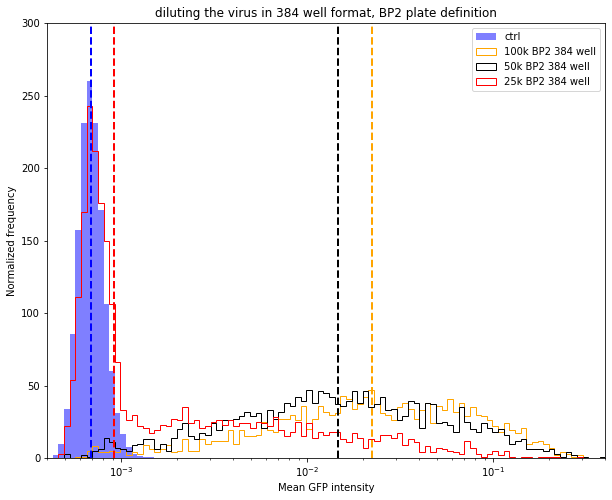

{'ctrl': 0.0006847176859009832,
 '100k BP2 384 well': 0.022231471174558915,
 '50k BP2 384 well': 0.01457934897871052,
 '25k BP2 384 well': 0.0009112033372898201}

In [29]:
set1 = ['100k BP2 384 well',f_BP2_100k_384]
set2 = ['50k BP2 384 well',f_BP2_50k_384]
set3 = ['25k BP2 384 well',f_BP2_25k_384]
ctrls_set = ['ctrl',f_ctrl_384,.02]

kwargs = {'x_range':[0.0004,.4],
          'y_range':[0,300],
          'bin_num':100,
          'x_label':'Mean GFP intensity',
          'title':'diluting the virus in 384 well format, BP2 plate definition',
          'abs_density':True,
         'log':True
         }

tf.PlotHist(ctrls_set, set1, set2, set3, **kwargs)

Nope, both SP2 and BP2 yield similar distributions on the per-cell expression level. -though the low BacMam amount shifts around

### How do the distributions look in 1536 well format?

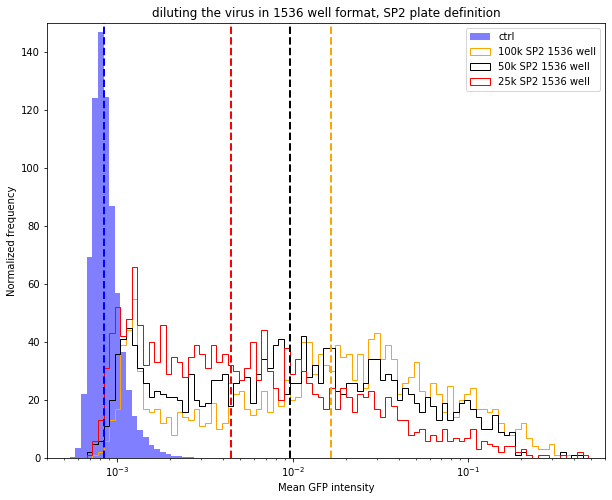

{'ctrl': 0.0008389958795094262,
 '100k SP2 1536 well': 0.016589428872089983,
 '50k SP2 1536 well': 0.009670696043690554,
 '25k SP2 1536 well': 0.004460206837072411}

In [30]:
set1 = ['100k SP2 1536 well',f_SP2_100k_1536]
set2 = ['50k SP2 1536 well',f_SP2_50k_1536]
set3 = ['25k SP2 1536 well',f_SP2_25k_1536]
ctrls_set = ['ctrl',f_ctrl_1536,.005]

kwargs = {'x_range':[0.0004,.6],
          'y_range':[0,150],
          'bin_num':100,
          'x_label':'Mean GFP intensity',
          'title':'diluting the virus in 1536 well format, SP2 plate definition',
          'abs_density':True,
         'log':True
         }

tf.PlotHist(ctrls_set, set1, set2, set3, **kwargs)

Consistent with seeing a lower overall expression level, it looks like fewer cells are expressing GFP (note the population spike at the low end). Increasing transduction (BacMam levels) does increase the mean expression level and shifts the curve to the right.

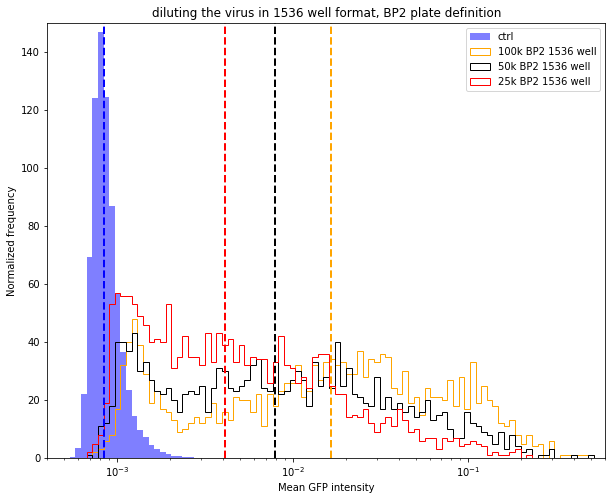

{'ctrl': 0.0008389958795094262,
 '100k BP2 1536 well': 0.01644591881062593,
 '50k BP2 1536 well': 0.00790147414158608,
 '25k BP2 1536 well': 0.004106644988408154}

In [31]:
set1 = ['100k BP2 1536 well',f_BP2_100k_1536]
set2 = ['50k BP2 1536 well',f_BP2_50k_1536]
set3 = ['25k BP2 1536 well',f_BP2_25k_1536]
ctrls_set = ['ctrl',f_ctrl_1536,.005]

kwargs = {'x_range':[0.0004,.6],
          'y_range':[0,150],
          'bin_num':100,
          'x_label':'Mean GFP intensity',
          'title':'diluting the virus in 1536 well format, BP2 plate definition',
          'abs_density':True,
         'log':True
         }

tf.PlotHist(ctrls_set, set1, set2, set3, **kwargs)

Essentially the same with the echo BP2 dispense definition

### Lets take a look at a well with high transduction levels vs no transduction, 384 well format

In [73]:
# Set the relative intensity that will be used to display the 2 channels
nuc_intensity = 5
GFP_intensity = 80

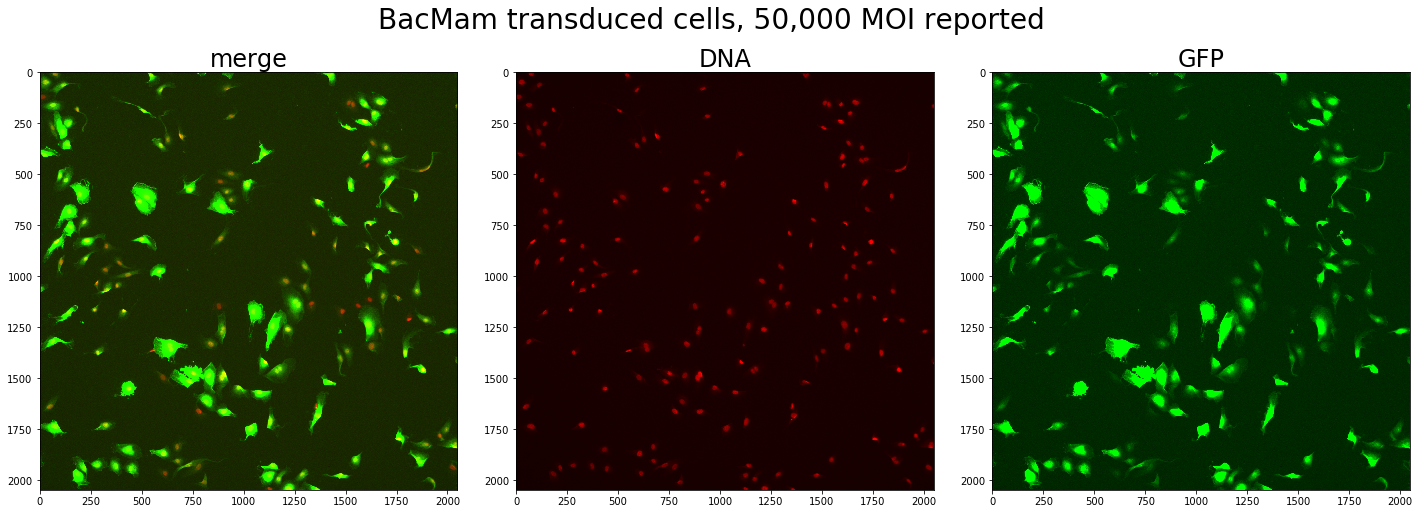

In [74]:
well = 'D05, s2'
merge_title = 'merge'
title = 'BacMam transduced cells, 50,000 MOI reported'
tf.ShowPanel(well, image_fileset_384, 
             R_scale = nuc_intensity, G_scale = GFP_intensity, #y_range = [1500,2000], x_range = [800,1300],
             G_title = 'GFP', M_title = merge_title, title = title, Absolute_scale = True)

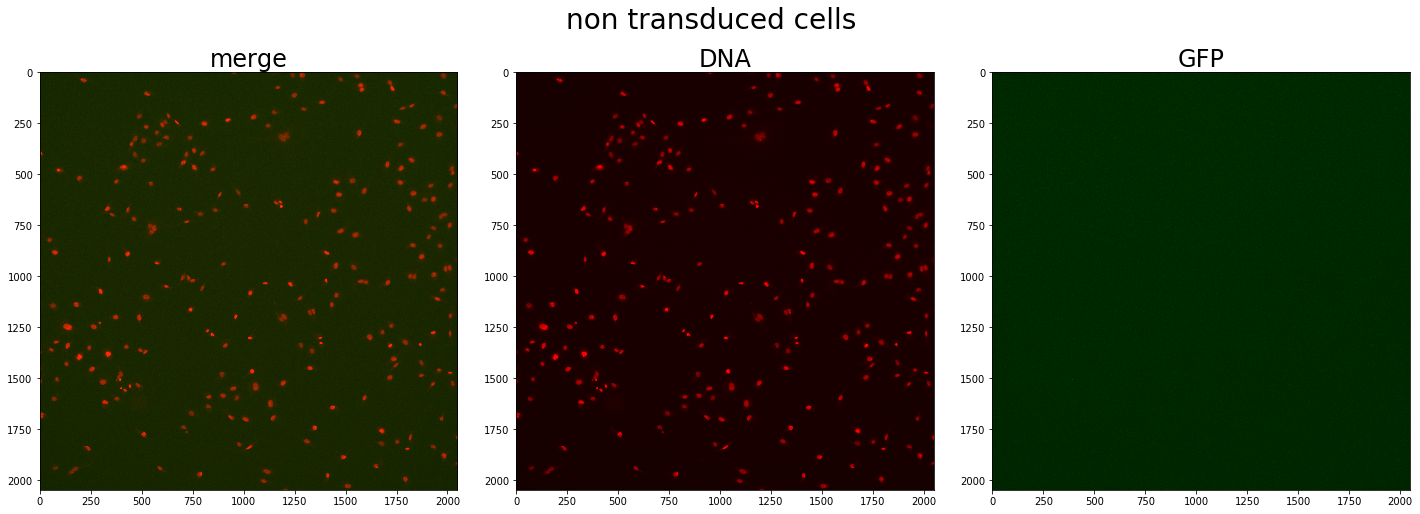

In [75]:
well = 'N05, s2'
merge_title = 'merge'
title = 'non transduced cells'
tf.ShowPanel(well, image_fileset_384, 
             R_scale = nuc_intensity, G_scale = GFP_intensity, #y_range = [1500,2000], x_range = [800,1300],
             G_title = 'GFP', M_title = merge_title, title = title, Absolute_scale = True)

## Conclusion
1. We can effectively use the Echo to dispense BacMam
2. The SP2 and BP2 dispense definitions are equivalent for dispensing BacMam
3. We can work in 1536 well format, though it will take some optimization to improve transduction efficiency